In [90]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Get OpenStreetMap Data

For this, we use the OSMPythonTools package as recommended by the OSM wiki. It allows us to access the Overpass API (a read-only API, perfect for what we are set to do), the OSM API, and the Nominatim access point. More info here: https://wiki.openstreetmap.org/wiki/OSMPythonTools

#### Which object does the way with the id 5887599 represent?

In [2]:
from OSMPythonTools.api import Api
api = Api()
way = api.query('way/5887599')

#### How many trees are in the OSM data of Vienna? And how many trees have there been in 2013?

In [3]:
# Find the id for the area Vienna
from OSMPythonTools.nominatim import Nominatim
nominatim = Nominatim()
areaId = nominatim.query('Vienna, Austria').areaId()
print('Vienna Id:', areaId)

Vienna Id: 3600109166


In [4]:
# query the Overpass API for the numbe of trees in Vienna using the id we just retrieved.
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass
overpass = Overpass()
query = overpassQueryBuilder(area=areaId, elementType='node', selector='"natural"="tree"', out='count')
result = overpass.query(query)
print('there are', result.countElements(), 'trees in Vienna')

there are 143275 trees in Vienna


In [5]:
# How many were there in 2013 ?
result = overpass.query(query, date='2013-01-01T00:00:00Z', timeout=60)
print('there were', result.countElements(), 'trees in Vienna in 2013')

there were 127690 trees in Vienna in 2013


#### How did the number of trees changed in Vienna, Paris and Berlin since 2013? 

In [11]:
from collections import OrderedDict
from OSMPythonTools.data import Data, dictRangeYears, ALL
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass

# The question has two "dimensions": the dimension of time, and the dimension of different cities: 
dimensions = OrderedDict([
    ('year', dictRangeYears(2013, 2017.5, 1)),
    ('city', OrderedDict({
        'berlin': 'Berlin, Germany',
        'paris': 'Paris, France',
        'vienna': 'Vienna, Austria',
    })),
])

In [12]:
# fetch the number of trees for the three cities, each year since 2013. It can take a while
overpass = Overpass()
def fetch(year, city):
    areaId = nominatim.query(city).areaId()
    query = overpassQueryBuilder(area=areaId, elementType='node', selector='"natural"="tree"', out='count')
    return overpass.query(query, date=year, timeout=60).countElements()
data = Data(fetch, dimensions)

[nominatim] downloading data: search
[overpass] downloading data: [timeout:60][date:"2013-01-01T00:00:00Z"][out:json];area(3600062422)->.searchArea;(node["natural"="tree"](area.searchArea);); out count;
[nominatim] downloading data: search
[overpass] downloading data: [timeout:60][date:"2013-01-01T00:00:00Z"][out:json];area(3600007444)->.searchArea;(node["natural"="tree"](area.searchArea);); out count;
[overpass] downloading data: [timeout:60][date:"2014-01-01T00:00:00Z"][out:json];area(3600062422)->.searchArea;(node["natural"="tree"](area.searchArea);); out count;
[overpass] downloading data: [timeout:60][date:"2014-01-01T00:00:00Z"][out:json];area(3600007444)->.searchArea;(node["natural"="tree"](area.searchArea);); out count;
[overpass] downloading data: [timeout:60][date:"2014-01-01T00:00:00Z"][out:json];area(3600109166)->.searchArea;(node["natural"="tree"](area.searchArea);); out count;
[overpass] downloading data: [timeout:60][date:"2015-01-01T00:00:00Z"][out:json];area(3600062422

In [153]:
# Plot it in a .jpg picture
data.plot(city=ALL, filename='example.png')

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'data' is not defined

In [15]:
# Or get it as a .csv
print(data.select(city=ALL).getCSV())

year,berlin,paris,vienna
2013.0,10180,1936,127690
2014.0,17971,26905,128906
2015.0,28277,90602,130279
2016.0,86769,103175,132294
2017.0,108432,103249,134617



# Can we get the streets from Edinburgh ?

Following the indications in :
    
https://automating-gis-processes.github.io/site/notebooks/L6/retrieve_osm_data.html

In [87]:
import osmnx as ox
import matplotlib.pyplot as plt
plt.style.use("dark_background")
%matplotlib inline

# Specify the name that is used to seach for the data
# place_name = "Bruntsfield, Edinburgh, Scotland"
place_name = "Tollcross, Edinburgh, Scotland"

# Fetch OSM street network from the location
graph = ox.graph_from_place(place_name)
# Plot the streets
fig, ax = ox.plot_graph(graph)

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


(-3.216190405, -3.189757295, 55.935601680000005, 55.949651319999994)

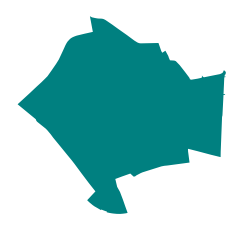

In [89]:
fig,ax = plt.subplots()
fig.patch.set_alpha(0)
area = ox.geocode_to_gdf(place_name)
area.plot(ax=ax, color='teal')
plt.axis('off')

# Get some specific info from OSM

(The outdated queries in the course have been updated as per changelog here: https://github.com/gboeing/osmnx/issues/526)

#### Bicycle lanes

As advised here: https://help.openstreetmap.org/questions/64879/get-all-bicycle-infrastructure-for-a-city

<blockquote>
To get all cycle infrastructure you will need to retrieve at least:
    <ul>
<li>all roads that have additional tags indicating cycle infrastructure (cycleway=lane and cycleway=track)</li>
<li>all highway=cycleway</li>
<li>all highway=footway and highway=path that allow bicycle use or are intended for such (bicycle=yes, bicycle=designated, bicycle=official)</li>
    </ul>
</blockquote>

#### Roads and highways

In [91]:
tags={'highway':True}
highways = ox.geometries_from_place(place_name, tags)
#highways.highway.value_counts()

#### How to extract the bike lanes from this?

In [92]:
import numpy as np

bicycle_filters = []

for column in ['cycleway', 'cycleway:left', 'cycleway:right', 'cycleway:both']:
    if column not in highways.columns: continue
    bicycle_filters.append(highways[column]=='lane')

bicycle_filters.append(highways['highway']=='cycleway')
bicycle_filters.append(highways['bicycle']=='designated')
bicycle_filters=np.array(bicycle_filters)
bicycle_filters=np.any(bicycle_filters, axis=0)

highways[bicycle_filters].loc['way', ['highway','bicycle','cycleway:both','geometry','lanes','nodes','oneway']].fillna('').head(3)

,highway,bicycle,cycleway:both,geometry,lanes,nodes,oneway
osmid,,,,,,,
3017282,pedestrian,designated,,"LINESTRING (-3.19159 55.93990, -3.19159 55.939...",,"[14348246, 6621481016, 444372419, 1880559364, ...",
4018916,cycleway,designated,,"LINESTRING (-3.19535 55.94010, -3.19538 55.940...",,"[6609905077, 3105814464, 208709529, 2269153500...",
4117480,footway,designated,,"LINESTRING (-3.20806 55.94764, -3.20822 55.94796)",,"[2337046429, 22453680]",
4117483,footway,designated,,"LINESTRING (-3.20841 55.94520, -3.20843 55.945...",,"[2337041854, 2337204162, 2337204163]",
4288268,cycleway,designated,,"LINESTRING (-3.20898 55.94186, -3.20898 55.941...",,"[25619789, 2911087971, 4932417637, 4932417636,...",
4417583,cycleway,designated,,"LINESTRING (-3.20614 55.93764, -3.20605 55.937...",,"[251126336, 1424966050, 3106973993, 21454112, ...",
4435845,tertiary,,,"LINESTRING (-3.19163 55.94526, -3.19210 55.945...",,"[10615990, 606393, 2292493126, 249966987, 5901...",
4526717,pedestrian,designated,,"LINESTRING (-3.21113 55.94139, -3.20909 55.942...",,"[22453491, 2395519385, 2272868841, 2293636277]",
5155504,pedestrian,designated,,"LINESTRING (-3.19142 55.94260, -3.19134 55.943...",,"[1703278758, 287842927, 37903884, 760111587, 3...",


#### Restaurants

In [93]:
tags = {'amenity':True, 'landuse':['restaurant']}
restaurants = ox.geometries_from_place(place_name, tags)
#restaurants.amenity.value_counts()

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


#### Buildings

In [94]:
tags = {'building':True}
buildings = ox.geometries_from_place(place_name, tags=tags)
#buildings.amenity.value_counts()

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


#### Bicycle rentals

In [166]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from pyproj import CRS

df_stations = pd.read_csv('df_stations.csv')
df_stations['geometry'] = df_stations[['station_lon','station_lat']].apply(lambda x : Point(*x), axis=1)
df_stations=gpd.GeoDataFrame(df_stations)
df_stations.crs = CRS.from_epsg(4326)

In [96]:
# Get the bike rentals in the specific neighbourhood we are looking at now
tags = {'amenity':'bicycle_rental'}
bike_stations = ox.geometries_from_place(place_name, tags)

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


#### Parks and green spaces

In [97]:
tags = {'leisure':True}
leisure = ox.geometries_from_place(place_name, tags)
#leisure.leisure.value_counts()

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


In [98]:
nodes, edges = ox.graph_to_gdfs(graph)

In [167]:
from pyproj import CRS

# Set projection
projection = CRS.from_epsg(3067)

# Re-project layers
#area = area.to_crs(projection)
edges = edges.to_crs(projection)
buildings = buildings.to_crs(projection)
restaurants = restaurants.to_crs(projection)
leisure = leisure.to_crs(projection)
highways = highways.to_crs(projection)
bike_stations = bike_stations.to_crs(projection)
df_stations = df_stations.to_crs(projection)

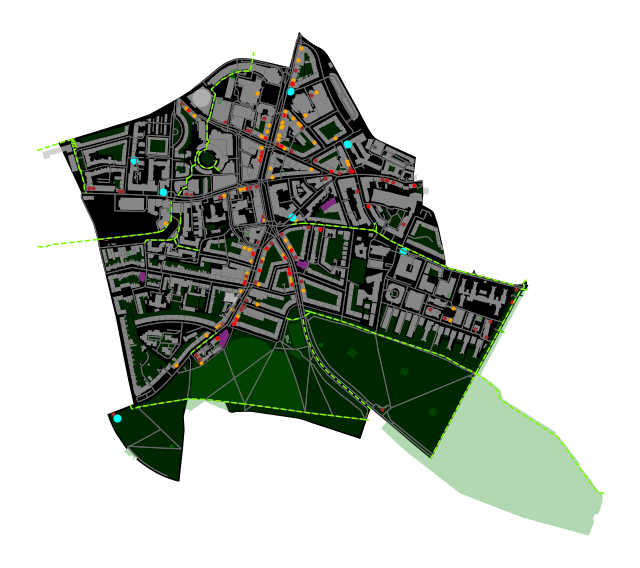

In [100]:
fig, ax = plt.subplots(figsize=(12,8))

fig.patch.set_alpha(0)

# AREAS
# Plot the footprint
area.plot(ax=ax, facecolor='black')
# Plot buildings
buildings.plot(ax=ax, facecolor='silver', alpha=0.7)
# Plot churches
restaurants[restaurants.amenity=='place_of_worship'].plot(ax=ax, color='purple', alpha=.7, markersize=10)
# Plot parks
leisure.plot(ax=ax, color='green', alpha=0.3, markersize=10)

# LINES
# Plot street edges
edges.plot(ax=ax, linewidth=1, edgecolor='dimgray')
# Plot cycle ways
highways[bicycle_filters].plot(ax=ax, color='lawngreen', alpha=1, ls='--')

# POINTS
# Plot restaurants
restaurants[restaurants.amenity=='restaurant'].plot(ax=ax, color='orange', alpha=1, markersize=10)
# Plot cafes
restaurants[restaurants.amenity=='cafe'].plot(ax=ax, color='brown', alpha=1, markersize=10)
# Plot fast food
restaurants[restaurants.amenity=='fast_food'].plot(ax=ax, color='red', alpha=1, markersize=10)
# Plot JustEat stations in cyan; 
bike_stations.plot(ax=ax, color='cyan', alpha=1, markersize=50)

plt.axis('off')

plt.tight_layout()

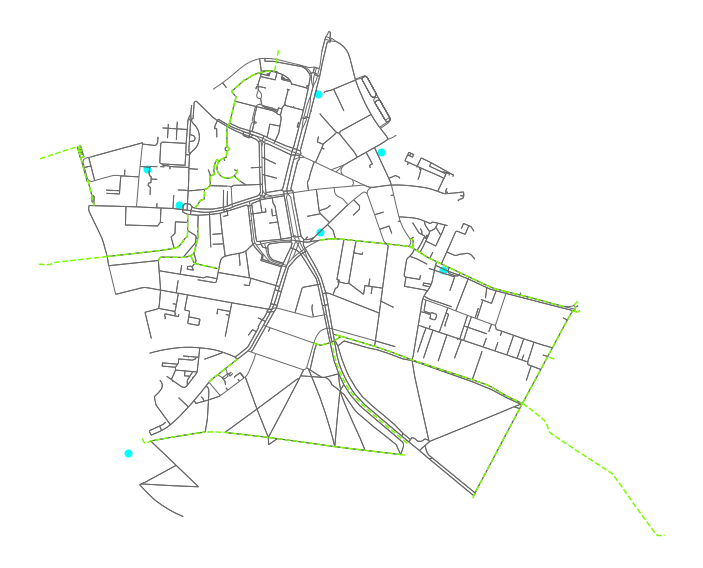

In [101]:
fig, ax = plt.subplots(figsize=(12,8))

fig.patch.set_alpha(0)

# LINES
# Plot street edges
edges.plot(ax=ax, linewidth=1, edgecolor='dimgray')
# Plot cycle ways
highways[bicycle_filters].plot(ax=ax, color='lawngreen', alpha=1, ls='--')

# POINTS
# Plot JustEat stations in cyan; 
bike_stations.plot(ax=ax, color='cyan', alpha=1, markersize=50)

plt.axis('off')

plt.tight_layout()

# Path from a bike rental to the next

Let's see if we can plot a trip from one station to the next.

In [102]:
import networkx as nx
import pandas as pd

# Retrieve only edges from the graph
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)
edges.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Now we will need some sort of metric system; therefore we need to project our graph: As the data is in WGS84 format, we should first reproject our data into a metric system. We can re-project the graph from latitudes and longitudes to an appropriate UTM zone:

In [168]:
graph_proj = ox.project_graph(graph)

# Get Edges and Nodes
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)
# Project the bike stations int our dataset in the same coordinates system
bike_stations_proj = bike_stations.to_crs(nodes_proj.crs)
# Project all bike stations in the same coordinates system
df_stations_proj = df_stations.to_crs(nodes_proj.crs)

# Get the Convex Hull of the network
convex_hull = edges_proj.unary_union.convex_hull
centroid = convex_hull.centroid

# Calculate the area
area = convex_hull.area

print("Coordinate system:", edges_proj.crs)

Coordinate system: +proj=utm +zone=30 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs


### Calculate network stats

In [104]:
# Calculate network statistics
stats = ox.basic_stats(graph_proj, circuity_dist='euclidean')

# Calculate statistics with density information
stats = ox.basic_stats(graph_proj, area=area)
extended_stats = ox.extended_stats(graph_proj, ecc=True, cc=True)

# Add extened statistics to the basic statistics
for key, value in extended_stats.items():
    stats[key] = value

# Convert the dictionary to a Pandas series for a nicer output
pd.Series(stats)

C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\osmnx\stats.py:317: UserWarning: The `circuity_dist` argument has been deprecated and will be removed in a future release.
  warnings.warn(msg)
C:\Users\darkj\miniconda3\envs\gis_lab\lib\site-packages\osmnx\stats.py:405: UserWarning: The extended_stats function has been deprecated and will be removed in a future release. Use NetworkX directly for extended topological measures.
  warnings.warn(msg)


n                                                                                    812
m                                                                                   2014
k_avg                                                                           4.960591
edge_length_total                                                              72841.196
edge_length_avg                                                                36.167426
streets_per_node_avg                                                            2.810345
streets_per_node_counts                 {0: 0, 1: 154, 2: 6, 3: 500, 4: 145, 5: 6, 6: 1}
streets_per_node_proportions           {0: 0.0, 1: 0.1896551724137931, 2: 0.007389162...
intersection_count                                                                   658
street_length_total                                                            39714.175
street_segment_count                                                                1099
street_length_avg    

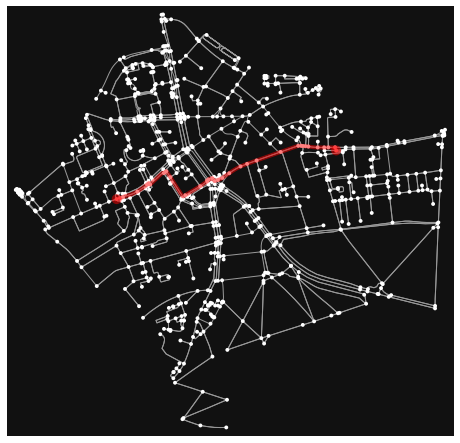

<Figure size 432x288 with 0 Axes>

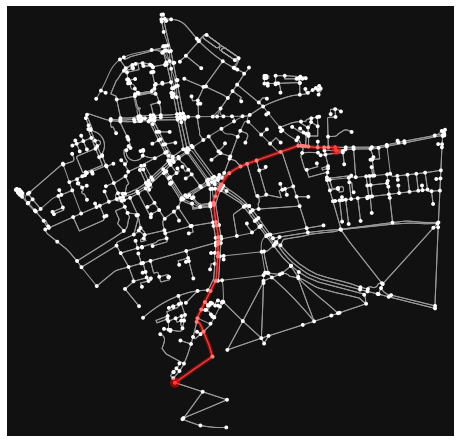

<Figure size 432x288 with 0 Axes>

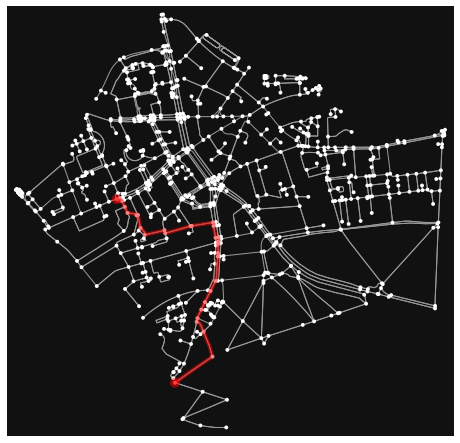

<Figure size 432x288 with 0 Axes>

In [108]:
for i in range(3):
    
    orig_node = ox.distance.nearest_nodes(graph_proj, *bike_stations_proj.iloc[i%3].geometry.xy)
    target_node = ox.distance.nearest_nodes(graph_proj, *bike_stations_proj.iloc[(i+1)%3].geometry.xy)
    
    route = nx.shortest_path(G=graph_proj, 
                             source=orig_node[0],
                             target=target_node[0],
                             weight='length')

    # Plot the shortest path
    fig, ax = ox.plot_graph_route(graph_proj, route)
    # Plot cycle ways
    highways[bicycle_filters].plot(ax=ax, color='lawngreen', alpha=1, ls='--')

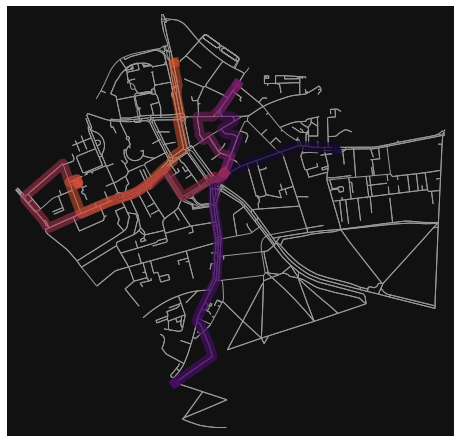

In [280]:
# Precious help from: https://stackoverflow.com/questions/25408393/getting-individual-colors-from-a-color-map-in-matplotlib
import matplotlib
cmap = matplotlib.cm.get_cmap('inferno')

routes=[]
rc=[]
i=0
for p1, p2 in zip(bike_stations_proj.geometry.values, bike_stations_proj.geometry.values.shift()):
    
    if p2 is None: continue
    
    orig_node = ox.distance.nearest_nodes(graph_proj, *p1.xy)
    target_node = ox.distance.nearest_nodes(graph_proj, *p2.xy)
    
    routes.append(nx.shortest_path(G=graph_proj, 
                             source=orig_node[0],
                             target=target_node[0],
                             weight='length'))
    
    color = '#%02x%02x%02x' % cmap(i/8, bytes=True)[:-1]
    rc.append(color)
    i+=1
    
fig, ax = ox.plot_graph_routes(graph_proj, routes, route_colors=rc, node_size=0, route_linewidths=10)

### Map each bicycle rental in the Just Eat Dataset to its equivalent in the OSM data

In [320]:
def find_closest(p, df):
    return df.loc[df.geometry.apply(lambda x : x.distance(p)).idxmin()].station_id

bike_stations_proj['JustEat_id'] = bike_stations_proj.geometry.apply(lambda p : find_closest(p, df_stations_proj))

# Map a bike factor through Edinburgh

In [321]:
factor_trips = pd.read_csv('factor_trips.csv')[['start_station_id', 'end_station_id', 'intensity']]

filter_1 = factor_trips.start_station_id.isin(bike_stations.JustEat_id)
filter_2 = factor_trips.end_station_id.isin(bike_stations.JustEat_id)

factor_trips = factor_trips[filter_1 & filter_2]

JustEat_coords = bike_stations_proj.set_index('JustEat_id').geometry.to_dict()

factor_trips['start_geo'] = factor_trips.start_station_id.apply(lambda x : JustEat_coords[x])
factor_trips['end_geo'] = factor_trips.end_station_id.apply(lambda x : JustEat_coords[x])

factor_trips.intensity = factor_trips.intensity/factor_trips.intensity.max()

factor_trips = gpd.GeoDataFrame(factor_trips)

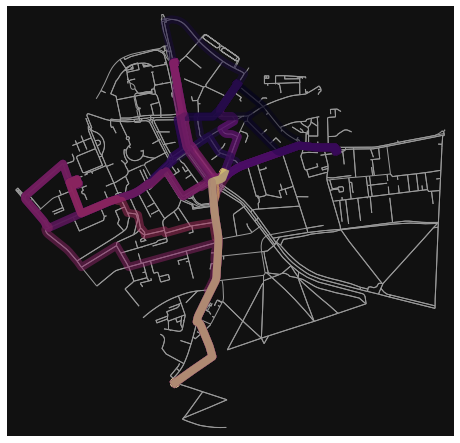

In [323]:
# Precious help from: https://stackoverflow.com/questions/25408393/getting-individual-colors-from-a-color-map-in-matplotlib
import matplotlib
cmap = matplotlib.cm.get_cmap('inferno')

routes=[]
rc=[]
i=0

for r in factor_trips.iterrows():
    row = r[1]
        
    orig_node = ox.distance.nearest_nodes(graph_proj, *row.start_geo.xy)
    target_node = ox.distance.nearest_nodes(graph_proj, *row.end_geo.xy)
    
    routes.append(nx.shortest_path(G=graph_proj, 
                             source=orig_node[0],
                             target=target_node[0],
                             weight='length'))
    
    color = '#%02x%02x%02x' % cmap(row.intensity, bytes=True)[:-1]
    rc.append(color)
    i+=1
    
fig, ax = ox.plot_graph_routes(graph_proj, routes, route_colors=rc, node_size=0, route_linewidths=8)